# Extrator de entidades - sequence to class - BiLSTM  e Attention

In [2]:
# Script for training neural model with embedding
import os, sys
import pandas as pd
import numpy as np
from omni.nlp import TextProcessing
from gensim.models import Word2Vec
import logging
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Input, LSTM, TimeDistributed, Bidirectional
from tensorflow.python.keras.layers import Concatenate
from sklearn.metrics import accuracy_score
from tensorflow.python.keras.models import load_model
import json
import string
from itertools import compress
from tensorflow.python.keras.models import Model as ModelKeras

from mlflow import log_metric, log_param, log_artifact, set_tracking_uri, set_experiment, start_run
import mlflow.tensorflow

project_path = "/home/andre.oliveira/attention_keras"
if project_path not in sys.path:
    sys.path.append(project_path)

from examples.utils.data_helper import read_data, sents2sequences
from examples.utils.model_helper import plot_attention_weights
from examples.utils.logger import get_logger

base_dir = "/home/andre.oliveira/attention_keras"
logger = get_logger("examples.seq2seq_model.train",os.path.join(base_dir, 'logs'))

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

translator = str.maketrans('', '', string.punctuation)
keys_translator = list(translator.keys())
key_to_change = [x == '-' for x in string.punctuation]
for key in list(compress(keys_translator, key_to_change)):
    translator[key] = " "

from collections import Counter
import operator

from layers.attention import AttentionLayer
from tqdm import tqdm

from tensorflow.python.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
config.gpu_options.per_process_gpu_memory_fraction = 0.25
sess = tf.Session(config=config)

from tensorflow.python.keras.utils import CustomObjectScope

/opt/anaconda3/envs/attention-keras3/lib/python3.6/site-packages/swifter/swifter.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/opt/anaconda3/envs/attention-keras3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/attention-keras3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/attention-keras3/lib/python3.6/site-packages/tensorflow/python/framewor

examples.seq2seq_model.train | INFO | Started log /home/andre.oliveira/attention_keras/logs/examples.seq2seq_model.train


## Funções auxiliares

In [3]:
#==================================================
#Functions

def text_preprocessing(txt):
    nlp = TextProcessing()
    txt = nlp.preprocess_str(txt=txt, clean_html=False, explode_digits=False)
    #txt = nlp.preprocess_str(txt=txt, clean_html=False)
    txt = txt.translate(translator)

    return txt


def convert_tokens_to_charvec_timeframes(dataframe=None, column_selected=None, embedding_model=None,
                                         char_max_length=None, max_length=None, char_to_int_dict=None):

    # Preparando o conjunto de dados de entrada com timestamps (vetores e indices)
    vectors_dim = 256

    dataX_vec = np.zeros([dataframe.shape[0], max_length, vectors_dim], dtype='float16')

    print(dataX_vec.shape)
    
    i = 0
    for index, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0]):
        seq = 0
        txt = str(row[column_selected])
        tokens = list(txt.split(" "))
        for item in tokens:
            if seq < max_length:
                # Evaluate a word
                word_vec = get_char_embedding_from_word(word=item, model_emb=embedding_model, char_to_int_dict=char_to_int_dict,
                                                        max_length=char_max_length)
                dataX_vec[i, seq, :] = word_vec
            else:
                break
            seq = seq + 1
        i = i + 1

    return dataX_vec

def get_char_embedding_from_word(word, model_emb, char_to_int_dict, max_length):
    dim = len(char_to_int_dict)
    encoded_data = np.zeros((1, max_length, dim), dtype='int')

    seq = 0
    for char in word:
        if seq < max_length:
            encoded_data[0, seq, char_to_int_dict[char]] = 1
            seq = seq + 1
        else:
            break

    # implementacao para uma entrada de seq
    states_value_seq = model_emb.predict(encoded_data)
    embedded_samples = states_value_seq[0][0]

    return embedded_samples


def convert_tokens_to_vec_timeframes_w2v(dataframe=None, column_selected=None, embedding_model=None, embedding_model_code=None,
                                         max_length=None, verbose=None):
    nlp = TextProcessing()
    if embedding_model_code == 'gensim_word2vec' or embedding_model_code == 'gensim_fasttext':

        # Preparando o conjunto de dados de entrada com timestamps (vetores e indices)
        vectors_dim = embedding_model.wv.vector_size

        dataX_vec = np.zeros([dataframe.shape[0], max_length, vectors_dim], dtype='float16')

        # Transforming txt lists to lists of lists
        nlp = TextProcessing()
        list_tokens_input = nlp.convert_txt_of_tokens_to_list_of_tokens_from_pandas(
            dataframe=dataframe,
            column_selected=column_selected)

        # Qtde de palavras a serem processadas
        list_tokens_flat = nlp.flat_list_2D(list_tokens_input)
        qtde_tokens_input = len(list_tokens_flat)
        qtde_tokens_dist = len(set(list_tokens_flat))

        # Qtde de palavras mapeadas no espaco
        qtde_tokens_espaco = len(embedding_model.wv.vocab)

        if verbose > 1:
            logging.info('Total of distinct tokens from dataset input : ' + str(qtde_tokens_dist))

        # iniciando contador de amostras
        index_sample = 0

        # iniciando o vetor de tamanhos de sentencas
        samples_len = np.zeros(len(list_tokens_input), dtype='int16')
        tokens_not_found = np.zeros(len(list_tokens_input), dtype='int16')
        tokens_not_found_txt = []
        samples_tokens_cover = np.zeros(len(list_tokens_input), dtype='float16')

        # para cada sentenca na matriz de entrada
        for line in tqdm(list_tokens_input):
            index_token = 0
            samples_len[index_sample] = len(line)
            # para cada token da sentenca de entrada
            for token in line:
                if index_token < max_length:
                    if token in embedding_model.wv.vocab:
                        # se o token existe no wv podemos validar um timeframe valido
                        dataX_vec[index_sample, index_token, :] = embedding_model.wv[token]
                    else:
                        # o token nao existe no espaco semantico - nao avancar no timeframe
                        tokens_not_found[index_sample] = tokens_not_found[index_sample] + 1

                        # armazenando lista de tokens nao encontrados
                        tokens_not_found_txt.append(token)

                        # qdo token nao é mapeado nao se considera no vetor de entrada (retorno do contador se nao estourou o limite)
                        if tokens_not_found[index_sample] < max_length:
                            index_token = index_token - 1
                        else:
                            index_token = max_length
                            if verbose > 1:
                                logging.error(
                                    'Not found embedding tokens enough to build this sample input: ' + str(line))

                index_token += 1

            # contabilizando cobertura de tokens
            samples_tokens_cover[index_sample] = (samples_len[index_sample] - tokens_not_found[index_sample]) / \
                                                 samples_len[index_sample]

            index_sample += 1

        # todo fazer revisao dos tokens e apresentar so um consolidado

        if verbose > 1:
            logging.info('Mean size of txt input (tokens): ' + str(samples_len.mean()))
            logging.info('Min size of txt input (tokens): ' + str(samples_len.min()))
            logging.info('Max size of txt input (tokens): ' + str(samples_len.max()))

            # Calculando cobertura do espaco semantico
            logging.info('Total of processed tokens: ' + str(qtde_tokens_input))
            logging.info('Total of not embedded tokens: ' + str(tokens_not_found.sum()))
            logging.info('Tokens volume embedding covering: ' + str(
                (qtde_tokens_input - tokens_not_found.sum()) / (qtde_tokens_input)))

        # Cobertura em variedade de tokens
        perc_cobertura = ((qtde_tokens_espaco) - (len(set(tokens_not_found_txt)))) / (qtde_tokens_espaco)

        if verbose > 1:
            logging.info('Tokens variety embedding covering: ' + str(perc_cobertura))

        # Padronizando a entrada de dados com uma dimensionalidade constante
        X_pad_vec = pad_sequences(dataX_vec, maxlen=max_length, dtype='float16', padding='post', truncating='post',
                                  value=0.0)

        return X_pad_vec, samples_tokens_cover
    else:
        raise (Exception('Invalid embedding model code selection: ' + embedding_model_code))
        return False

def plot_attention_weights2(encoder_inputs, attention_weights, classe):
    """
    Plots attention weights
    :param encoder_inputs: Sequence of word ids (list/numpy.ndarray)
    :param attention_weights: Sequence of (<word_id_at_decode_step_t>:<attention_weights_at_decode_step_t>)
    :param en_id2word: dict
    :param fr_id2word: dict
    :return:
    """

    if len(attention_weights) == 0:
        print('Your attention weights was empty. No attention map saved to the disk. ' +
              '\nPlease check if the decoder produced  a proper translation')
        return

    attention_mat = attention_weights[0]
    
    fig, ax = plt.subplots(figsize=(32, 32))
    ax.imshow(attention_mat)

    ax.set_xticks(np.arange(attention_mat.shape[1]))
    ax.set_yticks(np.arange(attention_mat.shape[0]))

    ax.set_xticklabels(classe)
    ax.set_yticklabels([inp if inp != 0 else "<Res>" for inp in encoder_inputs.split(' ')])

        
def convert_tokens_to_charvec_timeframes_text(txt=None, embedding_model=None,
                                         char_max_length=None, max_length=None, char_to_int_dict=None):
    # Preparando o conjunto de dados de entrada com timestamps (vetores e indices)
    vectors_dim = 256
    
    dataX_vec = np.zeros([1, max_length, vectors_dim], dtype='float16')
    
    tokens = list(txt.split(" "))
    seq = 0
    for item in tokens:
        if seq < max_length:
            # Evaluate a word
            word_vec = get_char_embedding_from_word(word=item, model_emb=embedding_model, char_to_int_dict=char_to_int_dict,
                                                    max_length=char_max_length)
            dataX_vec[0, seq, :] = word_vec
        else:
                break
        seq = seq + 1
    return dataX_vec

def convert_tokens_to_w2v_timeframes_text(txt=None, column_selected=None, embedding_model=None,
                                         char_max_length=None, max_length=None, char_to_int_dict=None):
    # Preparando o conjunto de dados de entrada com timestamps (vetores e indices)
    vectors_dim = embedding_model.wv.vector_size

    dataX_vec = np.zeros([1, max_length, vectors_dim], dtype='float16')
    
    tokens = list(txt.split(" "))
    seq = 0
    for item in tokens:
        if seq < max_length:
            # Evaluate a word
            if item in embedding_model.wv.vocab:
                # se o token existe no wv podemos validar um timeframe valido
                dataX_vec[0, seq, :] = embedding_model.wv[item]
                seq = seq + 1
        
    return dataX_vec

In [4]:
#create a integer dictionary from output text class
def build_integer_class_dictionary_from_pandas(df_data, column_selected):

    classes = []

    #collecting distinct tokens
    for index, row in df_data.iterrows():
        txt = str(row[column_selected])

        if txt not in classes:
            classes.append(txt)

    classes = sorted(list(classes))

    #reporting
    num_classes = len(classes)

    print('Number of unique classes:', num_classes)

    dict_int2txt = dict(
        [(i, tk) for i, tk in enumerate(classes)])
    dict_txt2int = dict(
        [(tk, i) for i, tk in enumerate(classes)])

    return dict_int2txt, dict_txt2int

#create one-hot encode from txt and integer dictionary
def build_one_hot_encoding_from_classes_target(df_data, column_selected, dict_txt2int):

    n_samples = df_data[column_selected].shape[0]
    dim = len(dict_txt2int)
    encoded_target_data = np.zeros((n_samples, dim), dtype='int')

    # assign 1's
    sample = 0
    for index, row in df_data.iterrows():

        txt = str(row[column_selected])
        encoded_target_data[sample, dict_txt2int[txt]] = 1
        sample = sample + 1

    return encoded_target_data

In [5]:
def balanced_sample_maker(X, y, sample_size, random_seed=None):
    """ return a balanced data set by sampling all classes with sample_size 
        current version is developed on assumption that the positive
        class is the minority.

    Parameters:
    ===========
    X: {numpy.ndarrray}
    y: {numpy.ndarray}
    """
    uniq_levels = np.unique(y)
    uniq_counts = Counter(y)

    if not random_seed is None:
        np.random.seed(random_seed)

    # find observation index of each class levels
    groupby_levels = {}
    for ii, level in enumerate(uniq_levels):
        obs_idx = [idx for idx, val in enumerate(y) if val == level]
        groupby_levels[level] = obs_idx
    # oversampling on observations of each label
    balanced_copy_idx = []
    for gb_level, gb_idx in groupby_levels.items():
        over_sample_idx = np.random.choice(gb_idx, size=sample_size, replace=True).tolist()
        balanced_copy_idx+=over_sample_idx
    np.random.shuffle(balanced_copy_idx)

    return balanced_copy_idx

In [49]:
def classifier_substantive_sequence_txt(input_text):
    
    input_seq1 = convert_tokens_to_charvec_timeframes_text(txt=input_text, embedding_model=wordchar2vec,
                                         char_max_length=max_char_lenght, max_length=max_length, char_to_int_dict=char_to_int_dict)
    input_seq2 = convert_tokens_to_w2v_timeframes_text(txt=input_text, embedding_model=word2vec,
                                         char_max_length=max_char_lenght, max_length=max_length, char_to_int_dict=char_to_int_dict)
    
    # Encode the input as state vectors.
    encoder_char_outputs, char_last_forward_h1, char_last_forward_c1, char_last_backward_h1, char_last_backward_c1 = encoder_char_model.predict(input_seq1)
    encoder_w2v_outputs, w2v_last_forward_h1, w2v_last_forward_c1, w2v_last_backward_h1, w2v_last_backward_c1 = encoder_w2v_model.predict(input_seq2)

    char_state_h = np.concatenate((char_last_forward_h1, char_last_backward_h1), axis=1)
    char_state_c = np.concatenate((char_last_forward_c1, char_last_backward_c1), axis=1)
    
    w2v_state_h = np.concatenate((w2v_last_forward_h1, w2v_last_backward_h1), axis=1)
    w2v_state_c = np.concatenate((w2v_last_forward_c1, w2v_last_backward_c1), axis=1)
    
    enc_state_h = np.concatenate((char_state_h, w2v_state_h), axis=1)
    #print(states_value_h.shape)
    enc_outs = np.concatenate((encoder_char_outputs, encoder_w2v_outputs), axis=2)

    
    decoder_inf_pred, attention_weights = classifier_model.predict([enc_outs, enc_state_h])
    
    key = np.argmax(decoder_inf_pred)
    
    return int_to_label_dict[key], attention_weights

In [50]:
def plot_attention_weights2(encoder_inputs, attention_weights, classe):
    """
    Plots attention weights
    :param encoder_inputs: Sequence of word ids (list/numpy.ndarray)
    :param attention_weights: Sequence of (<word_id_at_decode_step_t>:<attention_weights_at_decode_step_t>)
    :param en_id2word: dict
    :param fr_id2word: dict
    :return:
    """

    if len(attention_weights) == 0:
        print('Your attention weights was empty. No attention map saved to the disk. ' +
              '\nPlease check if the decoder produced  a proper translation')
        return

    attention_mat = attention_weights[0]
    
    fig, ax = plt.subplots(figsize=(32, 32))
    ax.imshow(attention_mat)

    ax.set_xticks(np.arange(attention_mat.shape[1]))
    ax.set_yticks(np.arange(attention_mat.shape[0]))

    ax.set_xticklabels(classe)
    ax.set_yticklabels([inp if inp != 0 else "<Res>" for inp in encoder_inputs.split(' ')])

## DataGenerator Tensorflow

In [6]:
import numpy as np
from tensorflow.python import keras


class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, names, labels, batch_size=50, dim_char=(30, 256), dim_w2v=(30, 100),
                 n_classes=None, shuffle=True, wordchar2vec=None, word2vec=None, max_char_lenght=10,
                 max_length=30 , char_to_int_dict=None):
        'Initialization'
        self.dim_char = dim_char
        self.dim_w2v = dim_w2v
        self.batch_size = batch_size
        self.labels = labels
        self.names = names
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.wordchar2vec = wordchar2vec
        self.wordchar2vec._make_predict_function()
        self.word2vec = word2vec
        self.max_char_lenght = max_char_lenght
        self.max_length = max_length
        self.char_to_int_dict = char_to_int_dict
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        [X_char, X_w2v], y = self.__data_generation(list_IDs_temp)
        #X_char, y = self.__data_generation(list_IDs_temp)
        return [X_char, X_w2v], y
        #return X_char, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X_char = np.empty((self.batch_size, *self.dim_char))
        X_w2v = np.empty((self.batch_size, *self.dim_w2v))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            
            X_char[i,] = convert_tokens_to_charvec_timeframes_text(txt = self.names[ID], embedding_model = self.wordchar2vec,
                                         char_max_length = self.max_char_lenght, max_length = self.max_length, char_to_int_dict = self.char_to_int_dict)
            
            X_w2v[i,] = convert_tokens_to_w2v_timeframes_text(txt = self.names[ID], embedding_model = self.word2vec,
                                         char_max_length = self.max_char_lenght, max_length = self.max_length, char_to_int_dict = self.char_to_int_dict)

            # Store class
            y[i] = self.labels[ID]

        return [X_char, X_w2v], keras.utils.to_categorical(y, num_classes=self.n_classes)
        #return X_char, keras.utils.to_categorical(y, num_classes=self.n_classes)

## Attention


In [7]:
# class Attention_Bahdanau(tf.keras.Model):
class Attention_Bahdanau(keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(Attention_Bahdanau, self).__init__(**kwargs)
        self.units = units
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)


    def call(self, inputs):
        hidden_with_time_axis = tf.expand_dims(inputs[1], 1)
        score = tf.nn.tanh(self.W1(inputs[0]) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * inputs[0]
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

    def get_config(self):
        config = super(Attention_Bahdanau, self).get_config()
        config.update({
            'units': self.units
        })
        return config

## Carregar e processar dataset

In [8]:
#==================================================
#Parameters
data_file_path = "data/labeled_offers_utilidades_domesticas_with_image.csv"
input_column = "name"
output_column = "substantive"
max_length = 30

char_embedding_model_file = "models/char_words_model_nd_256_es.h5"
input_w2v_file = "models/word-2-vectors-1000.bin"
char_to_int_dict_file = "models/char_to_int.json"
max_char_lenght = 10

n_hidden_nodes = 300
n_epochs = 100
n_batch = 50

log_dir_tensorboard = 'logs/seq2class-char-w2v-attention-substantive-30042020'
filepath = 's2cls_substantive_extract_char_w2v_attention_00.h5'

In [9]:
#set_experiment("/Users/andre.oliveira@omnilogic.com.br/seq2class_entity_extract_attention_char_w2v")
#run_name = "seq2class_entity_extract_attention_char_w2v_v00"
#start_run(run_name=run_name)
#log_param('n_hidden_nodes', n_hidden_nodes)

In [10]:
#==================================================
#Load data
df_dataset = pd.read_csv(data_file_path, error_bad_lines=False)

df_dataset_f = df_dataset[df_dataset[output_column] != '-']

df_dataset_f = df_dataset_f[df_dataset_f[input_column] != 'nan']

Retirar valores NAN do dataframe

In [11]:
list_to_drop = []
for x in range(df_dataset_f.shape[0]):
    if type(df_dataset_f.name.values[x]) != str:
        print(df_dataset_f.name.values[x])
        list_to_drop.append(df_dataset_f.index[x])
    if type(df_dataset_f.substantive.values[x]) != str:
        print(df_dataset_f.substantive.values[x])
        list_to_drop.append(df_dataset_f.index[x])

df_dataset_f = df_dataset_f.drop(list_to_drop)

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [12]:
df_dataset_f.shape

(540814, 12)

Quantidade de ofertas por entidade

In [13]:
dict_substantive_offer_count = Counter(df_dataset_f.substantive.values.tolist())
dict_substantive_offer_count = {k: v for k, v in sorted(dict_substantive_offer_count.items(), key=lambda item: item[1], reverse=True)}


In [14]:
dict_substantive_offer_count

{'Lustre': 30481,
 'Panela': 26657,
 'Pote': 24688,
 'Copo': 21261,
 'Faca': 18967,
 'Caneca': 18309,
 'Luminária': 16208,
 'Bandeja': 12068,
 'Taça': 11714,
 'Lâmpada': 11630,
 'Faqueiro': 11567,
 'Organizador': 10331,
 'Frigideira': 10197,
 'Torneira': 9622,
 'Porta Retrato': 9334,
 'Lixeira': 8850,
 'Prato': 8806,
 'Forma': 7639,
 'Colher': 7573,
 'Aparelho de jantar': 7290,
 'Assadeira': 5572,
 'Tigela': 5535,
 'Garrafa Térmica': 5440,
 'Churrasqueira': 5175,
 'Abajur': 5171,
 'Garrafa': 5036,
 'Travessa': 4955,
 'Chaleira': 4844,
 'Embalagem para Presente': 4810,
 'Espátula de Cozinha': 4663,
 'Balança': 4548,
 'Jarra': 4490,
 'Garfo': 4333,
 'Vela': 4303,
 'Tábua de Cozinha': 3812,
 'Porta Tempero': 3487,
 'Fruteira': 3444,
 'Conjunto para churrasco': 3411,
 'Centro de Mesa': 3269,
 'Escorredor de Louças': 3215,
 'Cabide': 3158,
 'Guardanapo': 3114,
 'Relógio de parede': 3056,
 'Sousplat': 3029,
 'Castiçal': 2890,
 'Concha': 2874,
 'Porta Guardanapo': 2872,
 'Porta Chaves': 2850,

In [15]:
np.mean(list(dict_substantive_offer_count.values()))

1110.501026694045

In [16]:
all_substantives = list(dict_substantive_offer_count.keys())

Número de classes

In [17]:
n_classes = len(all_substantives)
n_classes

487

Pré-Processamento dos camposde

In [18]:
#Pre processing txt
df_dataset_f[input_column] = df_dataset_f[input_column].swifter.apply(text_preprocessing)

Balanceamento das classes pela lista de IDs

In [19]:
list_all_ids = df_dataset_f.ID.values.tolist()

In [20]:
list_all_substantives = df_dataset_f.substantive.values.tolist()

In [21]:
unique_substantives = list(set(list_all_substantives))

In [22]:
len(unique_substantives)

487

In [23]:
balanced_copy_idx = balanced_sample_maker(list_all_ids, list_all_substantives, sample_size=100)

In [24]:
list_balanced_ids = [list_all_ids[index] for index in balanced_copy_idx]
list_balanced_substantives = [list_all_substantives[index] for index in balanced_copy_idx]

In [25]:
Counter(list_balanced_substantives)

Counter({'Conjunto Trinchante': 100,
         'Panela': 100,
         'Grelha': 100,
         'Suporte para Copos': 100,
         'Chaira': 100,
         'Pregador Multiuso': 100,
         'Panquequeira': 100,
         'Kit para Banho': 100,
         'Caldeira': 100,
         'Tampa para Copo': 100,
         'Coqueteleira': 100,
         'Porta Talheres': 100,
         'Saladeira': 100,
         'Forma para Fritar Ovo': 100,
         'Filtro de Água': 100,
         'Triturador Manual': 100,
         'Rodo': 100,
         'Molde para Massas': 100,
         'Capa para Roupas': 100,
         'Cuscuzeira': 100,
         'Saca-rolha': 100,
         'Conjunto para Queijo': 100,
         'Marcador de Taça': 100,
         'Patezeira': 100,
         'Jarra': 100,
         'Sanduicheira de Fogão': 100,
         'Porta Vela': 100,
         'Bomboniere': 100,
         'Desentupidor': 100,
         'Barca para Sushi': 100,
         'Suporte para Vassouras': 100,
         'Chapa para Churrasco': 100

Dicionário de conversão da classe de entidade para inteiros

In [26]:
int_to_label_dict , label_to_int_dict  = build_integer_class_dictionary_from_pandas(df_data=df_dataset_f,column_selected=output_column)

Number of unique classes: 487


Salvar arquivo json de dicionário pois o modelo retorna o valor inteiro da classe

In [27]:
int_to_label_dict_file = "models/int_to_label_brand.json"

with open(int_to_label_dict_file, "wb") as f:
    f.write(json.dumps(int_to_label_dict).encode("utf-8"))

Dicionário com os valores dos campos para o Datagenerator

In [29]:
dict_id_name = {}
dict_id_substantive = {}

for ind, row in tqdm(df_dataset_f.iterrows(), total = df_dataset_f.shape[0]):
    dict_id_name[df_dataset_f.ID[ind]] = df_dataset_f.name[ind]
    dict_id_substantive[df_dataset_f.ID[ind]] = label_to_int_dict[df_dataset_f.substantive[ind]]

100%|██████████| 540814/540814 [00:58<00:00, 9176.36it/s] 


In [30]:
#load input char embedding

model_char = load_model(char_embedding_model_file, compile=False)

encoder_inputs = model_char.input[0] #input_1
encoder_outputs, state_h_enc, state_c_enc = model_char.layers[2].output # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = ModelKeras(encoder_inputs, encoder_states)
wordchar2vec = encoder_model

with open(char_to_int_dict_file) as json_file:
    char_to_int_dict = json.load(json_file)

#load input word2vec embedding
word2vec = Word2Vec.load(input_w2v_file)

## Parâmetros do Modelo

In [31]:
params = {
          'dim_char': (30, 256),
          'dim_w2v': (30, 100),
          'batch_size': 200,
          'n_classes': len(label_to_int_dict.keys()),
          'shuffle': True, 
          'wordchar2vec': wordchar2vec,
          'word2vec': word2vec,
          'max_char_lenght': max_char_lenght,
          'max_length': max_length,
          'char_to_int_dict': char_to_int_dict
         }

## Divisão entre conjunto de treino e teste

In [32]:
data_train_val, data_test = train_test_split(list_balanced_ids, test_size=0.2, random_state=42)

In [33]:
data_train, data_val = train_test_split(data_train_val, test_size=0.2, random_state=42)

In [34]:
# Generators
training_generator = DataGenerator(data_train, dict_id_name, dict_id_substantive, **params)
validation_generator = DataGenerator(data_val, dict_id_name, dict_id_substantive, **params)

## Definição do modelo

In [35]:
encoder_char_inputs = Input(shape=(params['dim_char'][0], params['dim_char'][1]))
encoder_char = Bidirectional(LSTM(n_hidden_nodes, return_state=True, return_sequences=True, dropout=0.1))
encoder_char_outputs, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_char(encoder_char_inputs)

state_h1 = Concatenate()([forward_h1, backward_h1])
state_c1 = Concatenate()([forward_c1, backward_c1])
encoder_char_states = [state_h1, state_c1]

encoder_w2v_inputs = Input(shape=(params['dim_w2v'][0], params['dim_w2v'][1]))
encoder_w2v = Bidirectional(LSTM(n_hidden_nodes, return_state=True, return_sequences=True, dropout=0.1))
encoder_w2v_outputs, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_w2v(encoder_w2v_inputs)

state_h2 = Concatenate()([forward_h2, backward_h2])
state_c2 = Concatenate()([forward_c2, backward_c2])
encoder_w2v_states = [state_h2, state_c2]

encoder_states_h  = Concatenate()([state_h1, state_h2])
encoder_states_c  = Concatenate()([state_c1, state_c2])

encoder_outputs = Concatenate()([encoder_char_outputs, encoder_w2v_outputs])

# Attention layer
attn_layer = Attention_Bahdanau(units =4* n_hidden_nodes)
context_vector, attention_weights = attn_layer([encoder_outputs, encoder_states_h])

decoder_dense = Dense(units=params['n_classes'], activation='softmax')

decoder_pred = decoder_dense(context_vector)

model = ModelKeras([encoder_char_inputs, encoder_w2v_inputs], decoder_pred)

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

print(model.summary())


/opt/anaconda3/envs/attention-keras3/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:542: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  append_fn(tensor_proto, proto_values)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 256)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 30, 100)      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 30, 600), (N 1336800     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 30, 600), (N 962400      input_2[0][0]                    
__________________________________________________________________________________________________
concatenat

## Treinamento do Modelo

In [37]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                  patience=5, min_lr=0.001, verbose=1,
                                  mode='auto',
                                  cooldown=10)

earlystopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1,
                                  mode='auto')

checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='auto')

tensorb = TensorBoard(log_dir= log_dir_tensorboard)

callbacks_list = [reduce_lr, tensorb, checkpoint]

# Enable auto-logging to MLflow to capture TensorBoard metrics.
mlflow.tensorflow.autolog()


model.fit_generator(epochs=n_epochs, verbose=1,
                    generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=False,
                    workers=5,
                    callbacks=callbacks_list)

/opt/anaconda3/envs/attention-keras3/lib/python3.6/site-packages/mlflow/utils/autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
154/155 [============================>.] - ETA: 3s - loss: 2.2521 - acc: 0.6656
Epoch 00001: acc improved from -inf to 0.66687, saving model to s2cls_brand_extract_char_w2v_attention_00.h5
155/155 [==============================] - 656s 4s/step - loss: 2.2422 - acc: 0.6669 - val_loss: 0.6637 - val_acc: 0.8703
Epoch 2/100
154/155 [============================>.] - ETA: 2s - loss: 0.4824 - acc: 0.9064
Epoch 00002: acc improved from 0.66687 to 0.90658, saving model to s2cls_brand_extract_char_w2v_attention_00.h5
155/155 [==============================] - 623s 4s/step - loss: 0.4816 - acc: 0.9066 - val_loss: 0.3580 - val_acc: 0.9195
Epoch 3/100
154/155 [============================>.] - ETA: 3s - loss: 0.2462 - acc: 0.9484
Epoch 00003: acc improved from 0.90658 to 0.94839, saving model to s2cls_brand_extract_char_w2v_attention_00.h5
155/155 [==============================] - 641s 4s/step - loss: 0.2464 - acc: 0.9484 - val_loss: 0.2657 - val_acc: 0.9371
Epoch 4/100
154/155 [====

KeyboardInterrupt: 

## Carregar Modelo 

In [ ]:
filepath = 's2cls_substantive_extract_char_w2v_attention_00.h5'

In [ ]:
with CustomObjectScope({'Attention_Bahdanau': Attention_Bahdanau}):
    model = load_model(filepath)

In [ ]:
model.summary()

## Validação Modelo

In [40]:
encoder_char_inputs = model.input[0] #input_1
encoder_char = model.layers[2]
encoder_char_outputs, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_char(encoder_char_inputs)

encoder_char_model = ModelKeras(inputs = [encoder_char_inputs], outputs =[encoder_char_outputs, forward_h1, forward_c1, backward_h1, backward_c1])

encoder_w2v_inputs = model.input[1] #input_2
encoder_w2v = model.layers[3]
encoder_w2v_outputs, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_w2v(encoder_w2v_inputs)

encoder_w2v_model = ModelKeras(inputs = [encoder_w2v_inputs], outputs =[encoder_w2v_outputs, forward_h2, forward_c2, backward_h2, backward_c2])

encoder_inf_outputs = Input(shape=(max_length, 4*n_hidden_nodes,), name='encoder_inf_output')
encoder_inf_state_h = Input(shape=(4*n_hidden_nodes,), name='encoder_inf_states')
attn_layer = model.layers[8]
context_vector, attention_weights = attn_layer([encoder_inf_outputs, encoder_inf_state_h])

decoder_dense = model.layers[9]
decoder_inf_pred=decoder_dense(context_vector)

classifier_model = ModelKeras(inputs=[encoder_inf_outputs, encoder_inf_state_h],
                           outputs=[decoder_inf_pred, attention_weights])


Conjunto de Treino e validação

In [41]:
input_texts = [dict_id_name[_id] for _id in data_train_val]
target_substantive = [dict_id_substantive[_id] for _id in data_train_val]

In [46]:
target_substantive = [int_to_label_dict[ind] for ind in target_substantive]

In [47]:
target_substantive

['Kit Dispenser',
 'Porta Relógio',
 'Amônia',
 'Descaroçador',
 'Tábua de Cozinha',
 'Capa Térmica para Tábua de Passar Roupa',
 'Furador de Coco',
 'Bandeja Perfurada para Cuba',
 'Meleira',
 'Boleador',
 'Saco Plástico com Lacre',
 'Esfregão',
 'Potiche',
 'Porta Panetone',
 'Farinheira',
 'Conjunto Trinchante',
 'Pegador',
 'Folha Protetora para Fogão',
 'Porta Papel Higiênico',
 'Porta Tempero',
 'Cuscuzeira',
 'Pano',
 'Cortador de Alimentos',
 'Luva de Cozinha',
 'Saleiro',
 'Injetor de Temperos',
 'Descanso de Pratos',
 'Saco para Confeitar',
 'Aplicador de Fita Adesiva',
 'Batedor Manual',
 'Bule',
 'Carrinho de Feira',
 'Cuscuzeira',
 'Torneira',
 'Espremedor',
 'Kit Capas para Cozinha',
 'Caneta para Confeitaria',
 'Suporte para Esponja',
 'Jogo de Café da Manhã',
 'Porta-moedas',
 'Botijão Térmico',
 'Furador de Coco',
 'Prendedor de Embalagem',
 'Aparelho de Fondue',
 'Faqueiro',
 'Forma',
 'Copo Medidor',
 'Cápsulas para Sifão de Chantilly',
 'Bandeja para Banheiro',
 'Pe

In [51]:
seq_index = 45
classe, attention_weights = classifier_substantive_sequence_txt(input_texts[seq_index])
classe

'Forma'

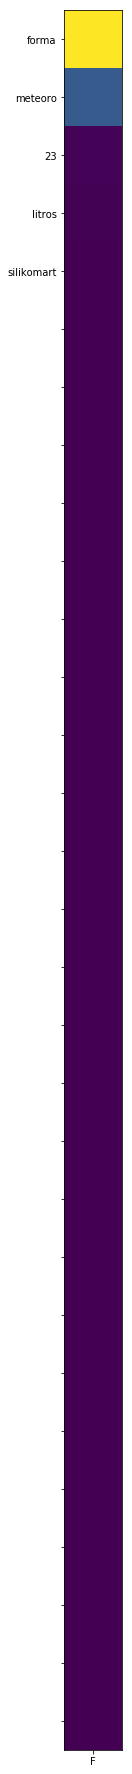

In [52]:
plot_attention_weights2(input_texts[seq_index], attention_weights, classe)

In [55]:
for seq_index in range(300):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    classe, attention_weights = classifier_substantive_sequence_txt(input_texts[seq_index])
    print(f'-{seq_index}')
    print('Input sentence:', input_texts[seq_index])
    print('Target:', target_substantive[seq_index])
    print('Predict:', classe)

-0
Input sentence: kit dispenser para bebidas  6 canecas que cozinha
Target: Kit Dispenser
Predict: Kit Dispenser
-1
Input sentence: porta relogios com 8 divisorias branco poli design
Target: Porta Relógio
Predict: Porta Relógio
-2
Input sentence: amonia diluida hemafarma 60 ml
Target: Amônia
Predict: Amônia
-3
Input sentence: descarocador de maca aco inox ghidini 22 cm 21728
Target: Descaroçador
Predict: Descaroçador
-4
Input sentence: tabua de corte em vidro decorada yoi lemons 35x25 cm
Target: Tábua de Cozinha
Predict: Tábua de Cozinha
-5
Input sentence: capa termica para tabua de passar roupa mor 4021
Target: Capa Térmica para Tábua de Passar Roupa
Predict: Capa Térmica para Tábua de Passar Roupa
-6
Input sentence: furador de coco inox ke home
Target: Furador de Coco
Predict: Furador de Coco
-7
Input sentence: bandeja perfurada inox 42x36 cm tramontina 94532014
Target: Bandeja Perfurada para Cuba
Predict: Bandeja Perfurada para Cuba
-8
Input sentence: meleira brinox 2396 101 em aco

-70
Input sentence: conjunto para servir arroz 2 pecas em aco inox zanella
Target: Conjunto para Servir
Predict: Conjunto para Servir
-71
Input sentence: conjunto magic kidchen pipoca facil dtc
Target: Pipoqueira para Microondas
Predict: Pipoqueira para Microondas
-72
Input sentence: aplicador de fita adesiva 50 mm jocar 98004
Target: Aplicador de Fita Adesiva
Predict: Aplicador de Fita Adesiva
-73
Input sentence: barril esconderijo toca pequeno enfeite para aquario shop everest
Target: Barril
Predict: Barril
-74
Input sentence: dispensador de copo 4 tubos inox agua e cafe e20 m jsn
Target: Coletor de Copos Descartável
Predict: Coletor de Copos Descartável
-75
Input sentence: latao para leite plastico 50 l hulk sgamaq
Target: Leiteira
Predict: Leiteira
-76
Input sentence: capa divertida para galao de agua de 20 litros bebsi recanto da costura
Target: Capa para Galão de Água
Predict: Capa para Galão de Água
-77
Input sentence: bacia plastico 14 l verde cod 5539 sanremo
Target: Bacia
Pre

-137
Input sentence: cooler abs bco com garrafa de vidro vacu vin
Target: Cooler para Garrafa
Predict: Cooler para Garrafa
-138
Input sentence: arejador chuveirinho para torneira pia de cozinha e tanque silicone marini
Target: Arejador para Torneira
Predict: Arejador para Torneira
-139
Input sentence: separador de prateleiras metaltru
Target: Separador para Prateleira
Predict: Separador para Prateleira
-140
Input sentence: copo medidor para panelas eletricas oster
Target: Copo Medidor
Predict: Copo Medidor
-141
Input sentence: tampa de vidro 28 cm rechauds tramontina 62709284
Target: Tampa para Rechaud
Predict: Tampa para Rechaud
-142
Input sentence: conjunto para bolo 2 pcs 1525 132 brinox
Target: Conjunto para Bolo
Predict: Conjunto para Bolo
-143
Input sentence: furador de coco industrial fc 01 braesi
Target: Furador de Coco
Predict: Furador de Coco
-144
Input sentence: porta detergente em polipropileno rosa uz uz utilidades
Target: Porta-Detergente
Predict: Porta-Detergente
-145
In

-202
Input sentence: toalheiro termico para 1 toalha 220 v fio direito cromado flape
Target: Toalheiro
Predict: Toalheiro
-203
Input sentence: esteira para sushi plastico especial importado sudare shun kang
Target: Jogo para Sushi
Predict: Jogo para Sushi
-204
Input sentence: torneira misturador monocomando docol new edge 925306 de bancada cromada
Target: Misturador
Predict: Misturador
-205
Input sentence: luva termica algodao prata 33x18 cm 31100 casambiente
Target: Luva de Cozinha
Predict: Luva de Cozinha
-206
Input sentence: acendedor eletrico para churrasqueira e lareira 650 w anurb 220 v
Target: Acendedor
Predict: Acendedor
-207
Input sentence: aro cromado para lixeira brinox decorline alpha
Target: Aro para Lixeira
Predict: Aro para Lixeira
-208
Input sentence: porta geleia metal forma andrea 7 pecas forma inox
Target: Porta Geleia
Predict: Porta Geleia
-209
Input sentence: kit cabide de veludo cinza 5 pcs wtrhs 001 c westing
Target: Cabide
Predict: Cabide
-210
Input sentence: fo

-270
Input sentence: jogo de pratos fundos atenas porto brasil ceramica azul celeste 6 pecas
Target: Prato
Predict: Prato
-271
Input sentence: toalheiro plastico interfolha biovis
Target: Toalheiro
Predict: Manta para Grelha
-272
Input sentence: dispenser porta sacolas plasticas puxa saco de parede cores ou
Target: Dispenser de Sacola
Predict: Dispenser de Sacola
-273
Input sentence: bandeja em ardosia escrito sushi 25x17 cm dinasty
Target: Bandeja para Sushi
Predict: Bandeja para Sushi
-274
Input sentence: conjunto churrasco inox 14 pecas 22299011 tramontina
Target: Conjunto para churrasco
Predict: Conjunto para churrasco
-275
Input sentence: capa p botijao de gas 59 cm x 50 cm suzi branco vilela vilela enxovais
Target: Capa para Botijão de Gás
Predict: Capa para Botijão de Gás
-276
Input sentence: suporte para margarina brinox parma 1570 100
Target: Porta-margarina
Predict: Suporte Multiuso
-277
Input sentence: sacola de nylon para feira 37 x 45 com 6 cab
Target: Sacola de Feira
Pred

In [ ]:
predict_train = []

In [ ]:
for seq_index in tqdm(range(len(input_texts))):
    classe, attention_weights = classifier_substantive_sequence_txt(input_texts[seq_index])
    predict_train.append(classe)

In [ ]:
train_acc = accuracy_score(target_substantive, predict_train)
mlflow.log_metric('train_acc', train_acc)
train_acc

Conjunto de Teste

In [56]:
input_texts_test = [dict_id_name[_id] for _id in data_test]
target_substantive_test = [dict_id_substantive[_id] for _id in data_test]

In [57]:
for seq_index in range(300):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    classe, attention_weights = classifier_substantive_sequence_txt(input_texts_test[seq_index])
    print(f'-{seq_index}')
    print('Input sentence:', input_texts_test[seq_index])
    print('Target:', int_to_label_dict[target_substantive_test[seq_index]])
    print('Predict:', classe)

-0
Input sentence: meleira de plastico branca uz utilidades
Target: Meleira
Predict: Meleira
-1
Input sentence: kit para piscina mangueira 7 m  peneira  aspirador  esfregao sos da piscina
Target: Esfregão
Predict: Esfregão
-2
Input sentence: bomboniere de cristal com tampa wolff bari
Target: Bomboniere
Predict: Bomboniere
-3
Input sentence: dispenser para detergente 650 ml menta ou
Target: Porta-Detergente
Predict: Porta-Detergente
-4
Input sentence: porta sabonete liquido new belly vintage grafite ou
Target: Porta Sabonete Líquido
Predict: Porta Sabonete Líquido
-5
Input sentence: barra magnetica multiuso em polipropileno cor preto 55 cm linha imperador 2502 332 brinox
Target: Barra Multiuso
Predict: Barra Multiuso
-6
Input sentence: boneca de flor com haste ferro enfeite decoracao jardim casa cor roxo braslu
Target: Enfeite
Predict: Enfeite
-7
Input sentence: cesto cozedor a vapor de alimentos 26 cm retratil rio impex
Target: Cesto para Cozimento a Vapor
Predict: Cesto para Cozimento

-66
Input sentence: batedor para carnes brinox delphos 2300 303 em aco inox
Target: Batedor de Carne
Predict: Batedor de Carne
-67
Input sentence: a1 balde para pipoca sonic ultrafest
Target: Balde de Pipoca
Predict: Balde de Pipoca
-68
Input sentence: conjunto para bolo petunia brinox
Target: Conjunto para Bolo
Predict: Conjunto para Bolo
-69
Input sentence: topiaria em formato redondo natural g 1515342 cromus
Target: Enfeite
Predict: Enfeite
-70
Input sentence: porta lencos london bus the home
Target: Porta Lenços de Papel
Predict: Porta Lenços de Papel
-71
Input sentence: modelador de hamburguer hercules inox
Target: Modelador de Alimentos
Predict: Modelador de Alimentos
-72
Input sentence: filtro agua plastico com cuba decorada preto 14 litros com 2
Target: Filtro de Água
Predict: Filtro de Água
-73
Input sentence: escorredor de macarrao em inox com alca meganeew
Target: Escorredor de Alimentos
Predict: Escorredor de Alimentos
-74
Input sentence: barco 23x14x3 cm branco ceraflame t

-133
Input sentence: varal de parede individual aco 12 m master innovar maxeb branco
Target: Varal
Predict: Varal
-134
Input sentence: gavetex cromado 37 cm arthi
Target: Gaveteiro Organizador
Predict: Gaveteiro Organizador
-135
Input sentence: esteira de silicone cinza lol
Target: Tapete de Pia
Predict: Tapete de Pia
-136
Input sentence: marcador de mesa 61595031 tramontina
Target: Marcadores de Mesa
Predict: Marcadores de Mesa
-137
Input sentence: anel expansivel para fatiar bolos inox prana
Target: Anel Expansível para Fatiar Bolos
Predict: Anel Expansível para Fatiar Bolos
-138
Input sentence: manta grill para churrasqueira teflon prime grill churrasco rodabrill
Target: Manta para Grelha
Predict: Manta para Grelha
-139
Input sentence: kit para confeitar com 5 bicos e 1 saco doupan dou 440
Target: Conjunto para Confeitar
Predict: Conjunto para Confeitar
-140
Input sentence: cesta para fritura em aco inox
Target: Organizador
Predict: Cesta de Fritura
-141
Input sentence: boleador uti

-202
Input sentence: capa externa para queimador brastemp
Target: Capa do Queimador de Fogão
Predict: Capa do Queimador de Fogão
-203
Input sentence: saladeira sfera 5 lts natural ouss 5690 nt ou
Target: Saladeira
Predict: Saladeira
-204
Input sentence: escada de agilidade dupla acte acte sports
Target: Escada
Predict: Escada
-205
Input sentence: palito p sanduiche c 200 theoto
Target: Palito para Sanduíche
Predict: Palito para Sanduíche
-206
Input sentence: amassador batatas inox yangzi com 3
Target: Amassador de Alimentos
Predict: Amassador de Alimentos
-207
Input sentence: descarocador cuisipro 20 cm 30025
Target: Descaroçador
Predict: Descaroçador
-208
Input sentence: decanter elixir legnoart
Target: Decanter
Predict: Decanter
-209
Input sentence: descanso para talher de ceramica le creuset azul marseille 26607
Target: Descanso para Talheres
Predict: Descanso para Talheres
-210
Input sentence: recipiente para banho maria 16 cm 61616160 tramontina
Target: Recipiente para Banho-Maria

-268
Input sentence: kit churrasco inox 17 pecas polywood mogno tramontina
Target: Conjunto para churrasco
Predict: Conjunto para churrasco
-269
Input sentence: porta adocante acrilico linus interdesign 113x55x5 cm 101998
Target: Porta Adoçante
Predict: Porta Adoçante
-270
Input sentence: relogio de mesa preto c laranja redondo 13x8 cm ponto sul
Target: Relógio de Mesa
Predict: Relógio de Mesa
-271
Input sentence: cortador de massa de madeira spaghetti chitarra 49 x 22 x 9 cm 25632
Target: Cortador de Massa
Predict: Cortador de Massa
-272
Input sentence: afiador de faca aco inox cozinha bar restaurante lanchonete industria nacional
Target: Afiador
Predict: Afiador
-273
Input sentence: capa para microondas 30 litros protecao uv preto oficina dos relogios
Target: Capa para Micro-ondas
Predict: Capa para Micro-ondas
-274
Input sentence: batedor de clara inox twin zwilling 23 cm 16871
Target: Batedor Manual
Predict: Batedor Manual
-275
Input sentence: papel toalha interfolha luxo 4800 folh

In [ ]:
predict_test = []

In [ ]:
for seq_index in tqdm(range(len(input_texts_test))):
    classe, attention_weights = classifier_substantive_sequence_txt(input_texts_test[seq_index])
    predict_test.append(classe)

In [ ]:
test_acc = accuracy_score(target_substantive_test, predict_test)
mlflow.log_metric('test_acc', test_acc)
test_acc